# E-commerce Fraud Detection Analysis

## 1. Exploratory Data Analysis

### Read CSV and understand data format

In [3]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [158]:
# datafiles
glob.glob('./data/*')

['./data/test_transaction.csv',
 './data/train_identity.csv',
 './data/test_identity.csv',
 './data/sample_submission.csv',
 './data/train_transaction.csv']

In [159]:
df_id = pd.read_csv('./data/train_identity.csv')
df_transaction = pd.read_csv('./data/train_transaction.csv')

### Identity Table

There are 41 columns in this table, including different 
identity information such as network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. These data is collected by Vesta’s fraud protection system and digital security partners. Field names are masked for privacy reasons.

Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

In [160]:
df_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [198]:
len(df_id.columns)

41

### Transaction Table

There are 394 columns in this table. The organization provided additinoal explanation regarding these variables.
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

In [162]:
df_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [163]:
len(df_transaction.columns)

394

### Data Exploration

In [164]:
df = df_id.join(df_transaction.set_index('TransactionID'), on='TransactionID')

Out of 590,540 data records, only ~3.5% are fraud transactions. It is very likely to encounter inbalanced classes in fraud detection problems. We will experiment with different ways to handle this, including various data sampling methods and using non-accuracy measures to evaluate model.

In [165]:
'Total number of Transactions', len(df_transaction.isFraud)

('Total number of Transactions', 590540)

('Ratio of fradulent transactions', 0.03499)

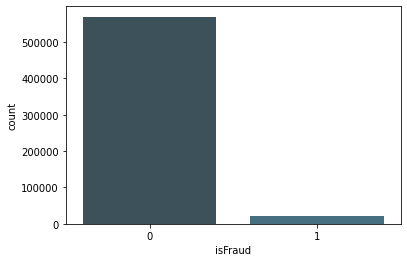

In [166]:
sns.set_palette('GnBu_d')
sns.countplot(x = 'isFraud', data = df_transaction)
'Ratio of fradulent transactions'\
, round(sum(df_transaction.isFraud)/ len(df_transaction.isFraud),5)

###  Read cleaned data from pickle 

Preprocessing applied to all files:
- Features with > 90% data missing or > 90% data with the same value were dropped
- If possible, categorical variables with 100s of categories were mapped to coaser categoricals
- Correlation plot analysis done on "V" columns and columns were dropped reduce collinearlity
	- https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
- Some "D" columns were normalized for time
- Aggregate features were added using "magic" technique
	- https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600#How-the-Magic-Works
- Dropped TransactionID and TransactionDT

In [4]:
import pickle

In [5]:
glob.glob('./data/clean_data/*')

['./data/clean_data/XGBoost_test_X_2.pkl',
 './data/clean_data/XGBoost_test_X_1.pkl',
 './data/clean_data/XGBoost_train_X_2.pkl',
 './data/clean_data/train_y.pkl',
 './data/clean_data/XGBoost_train_X_1.pkl',
 './data/clean_data/readmefirst.md']

In [16]:
'''X (version 1)
- Full 200 features
- Dummies created
'''
X_test_1 = pickle.load(open('./data/clean_data/XGBoost_test_X_1.pkl', 'rb'))
X_train_1 = pickle.load(open('./data/clean_data/XGBoost_train_X_1.pkl', 'rb'))

'''
X (version 2)
- Removed additional features
    - Highly correlated "C", "D" features
    - Removed features Chris (1st place winners) removed
    - Removed caterogical features withh 200+ categories even after 1)
- Dummies created
'''
X_test_2 = pickle.load(open('./data/clean_data/XGBoost_test_X_2.pkl', 'rb'))
X_train_2 = pickle.load(open('./data/clean_data/XGBoost_train_X_2.pkl', 'rb'))

y = pickle.load(open('./data/clean_data/train_y.pkl', 'rb'))

In [17]:
X_train_1.shape, X_train_2.shape, X_test_1.shape, X_test_2.shape, y.shape

((590540, 1323), (590540, 1303), (506691, 1573), (506691, 1553), (590540,))

### XGBoost model

In [18]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import xgboost as xgb
from sklearn.metrics import make_scorer

#### Since xgboost takes a considerable amount of time to run on non-GPU device, the following is a train-test split setup to assist with early stage coding/ debugging.

In [19]:
seed = 123
test_size = 0.3
X_train, X_val, y_train, y_val = train_test_split(X_train_1, y, test_size = test_size, random_state = seed)

In [20]:
model = xgb.XGBClassifier(eval_metric='auc')
model.fit(X_train, y_train)
print(model)

AttributeError: module 'xgboost' has no attribute 'XGBClassifier'

In [177]:
y_pred = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred)
print(f"ROC_AUC score: {auc_score* 100:.2f}%")
m1_frp, m1_tpr, _ = roc_curve(y_test, y_pred)

ROC_AUC score: 92.76%


In [178]:
model2 = XGBClassifier(n_estimators=2000,
max_depth=12, 
learning_rate=0.02, 
subsample=0.8,
colsample_bytree=0.4, 
missing=-1, 
eval_metric='auc',
tree_method='hist')

In [179]:
model2.fit(X_train, y_train)
y_pred = model2.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred)
print(f"ROC_AUC score: {auc_score* 100:.2f}%")

ROC_AUC score: 96.85%


In [180]:
m2_frp, m2_tpr, _ = roc_curve(y_test, y_pred)

In [181]:
no_skill_pred = [0 for _ in range(len(y_test))]
ns_frp, ns_tpr, _ = roc_curve(y_test, no_skill_pred)

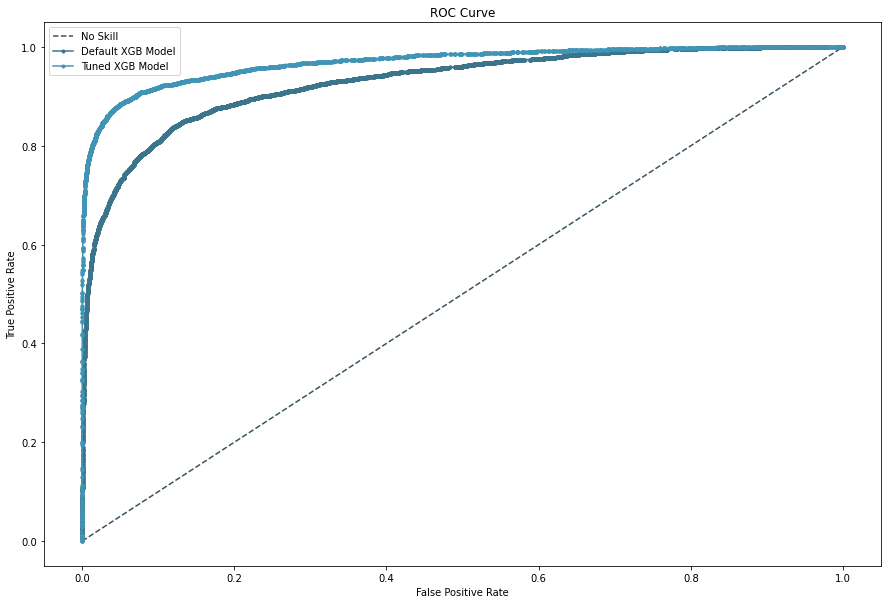

In [200]:
# plot ROC curve across models
plt.figure(figsize=(15, 10))
plt.plot(ns_frp, ns_tpr, linestyle = '--', label='No Skill')
plt.plot(m1_frp, m1_tpr, marker = '.', label='Default XGB Model')
plt.plot(m2_frp, m2_tpr, marker = '.', label='Tuned XGB Model')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

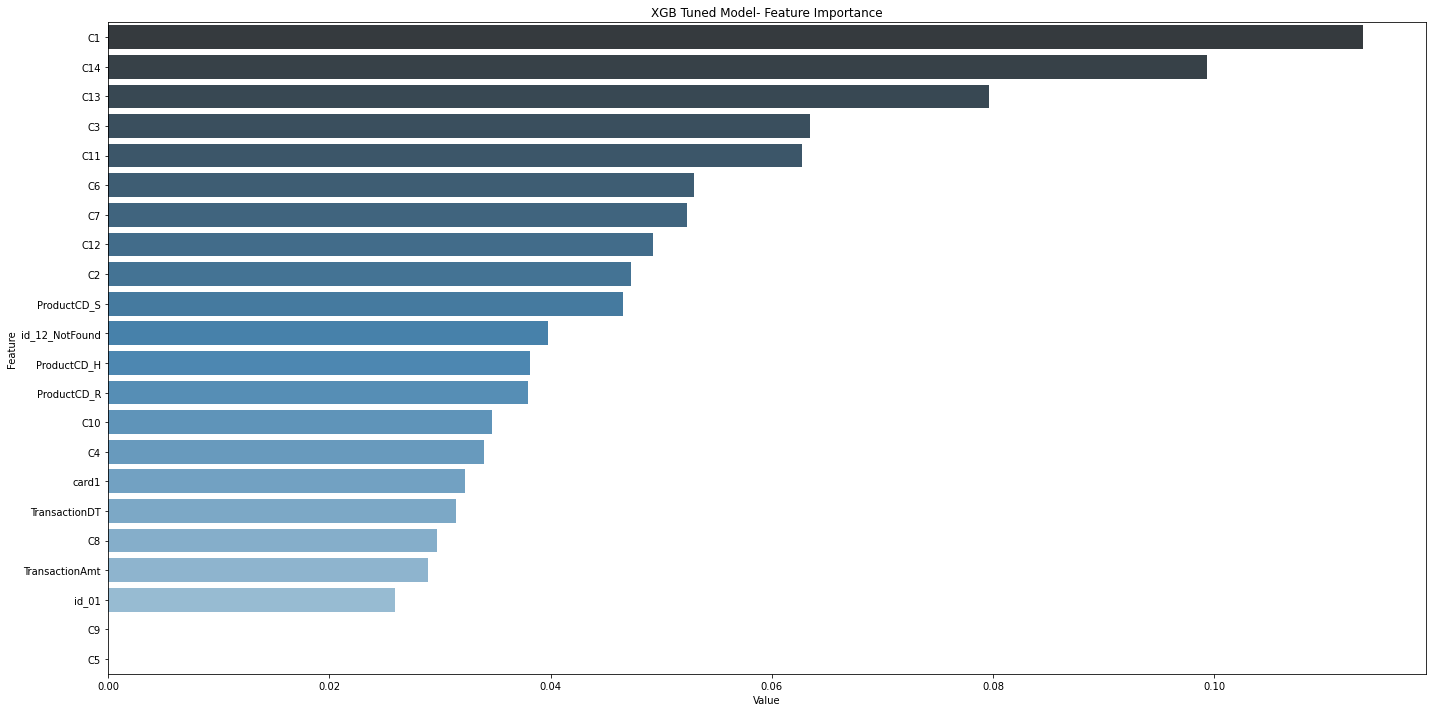

In [197]:
# Understand feature importance in the model
feature_imp = pd.DataFrame(sorted(zip(model2.feature_importances_,X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50],\
            palette = "Blues_d")
plt.title('XGB Tuned Model- Feature Importance')
plt.tight_layout()
plt.show()

#### Cross validation framework setup for hyperparameters tuning

In [206]:
predictions = model2.predict(X_test)


In [207]:
sum(predictions)/len(predictions)

0.05960249595562746

In [ ]:
# also set up cross validation framework for hyperparameters tuning
cv_scores = cross_validate(model2, X, y, cv =3 , scoring=('roc_auc')\
                           , return_train_score=True)

In [ ]:
cv_scores

In [ ]:
# To-do: explore the differences between ‘roc_auc’, ‘roc_auc_ovr’,‘roc_auc_ovo’,
#roc_auc_ovr_weighted’,‘roc_auc_ovo_weighted’

In [ ]:
# Use Scikit-learn's GridSearch CV for next steps